# Tickets analysis with statsmodels

In [1]:
import pandas as pd
import statsmodels.formula.api as smf
import numpy as np

pd.set_option("display.max_columns", 100)
pd.set_option("display.max_colwidth", 100)

In [3]:
# Unknown data is always coded as 'U', so we'll pass that to na_values
df = pd.read_csv('data/tickets-warnings.csv', na_values='U')

# Get rid of a lot of columns we don't care about
df = df[['TYPE','AGENCY3','SEX','BLACK','ASIAN','HISPANIC','MINORITY','AGE','MPH','MPHOVER','INTOWN', 'INSTATE', 'DAYNIGHT']].copy()

df.head(2)

,TYPE,AGENCY3,SEX,BLACK,ASIAN,HISPANIC,MINORITY,AGE,MPH,MPHOVER,INTOWN,INSTATE,DAYNIGHT
0,T,S,M,0.0,0.0,0.0,W,21.0,80,15.0,N,Y,day
1,T,S,F,0.0,0.0,0.0,W,36.0,0,NaN,N,Y,day


In [15]:
df['is_ticketed'] = df.TYPE.replace({
'T': 1,
'W': 0
})

In [25]:
df.INTOWN.unique()

array(['N', 'Y', nan], dtype=object)

In [26]:
df['is_intown'] = df.TYPE.replace({
'N': 0,
'Y': 1
})

## Basic analysis

In [4]:
pd.crosstab(df.MINORITY, df.TYPE) 

TYPE,T,W
MINORITY,,
M,16072,12636
W,65624,68291


<AxesSubplot:xlabel='MINORITY'>

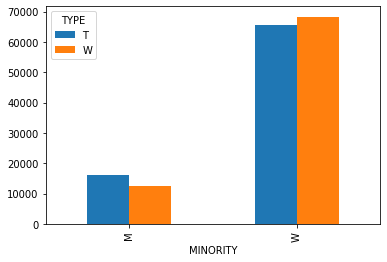

In [5]:
pd.crosstab(df.MINORITY, df.TYPE).plot(kind='bar') 

<AxesSubplot:xlabel='MINORITY'>

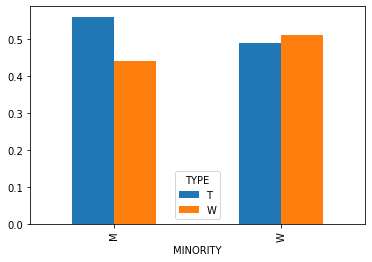

In [8]:
pd.crosstab(df.MINORITY, df.TYPE,normalize='index').plot(kind='bar') 

What does this not work?

## What are we interested in?

In [9]:
import statsmodels.formula.api as smf
import numpy as np 

In [20]:
model = smf.logit("""
    is_ticketed ~ MINORITY
""",data=df)

results = model.fit()

results.summary()

Optimization terminated successfully.
         Current function value: 0.691716
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            is_ticketed   No. Observations:               162623
Model:                          Logit   Df Residuals:                   162621
Method:                           MLE   Df Model:                            1
Date:                Thu, 05 Aug 2021   Pseudo R-squ.:                0.002048
Time:                        12:34:46   Log-Likelihood:            -1.1249e+05
converged:                       True   LL-Null:                   -1.1272e+05
Covariance Type:            nonrobust   LLR p-value:                2.033e-102
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.2405      0.012     20.230      0.000       0.217       0.264
MINORITY[T.W]    -0.2804      0.013    -21.425      0.000      -0.306      -0.255
=================================================================================
"""

In [21]:

coefs = pd.DataFrame({
'coef': results.params.values,
    # odds ratio above 1 my odds increase. below 1 it decrease
'odds ratio': np.exp(results.params.values),
'name': results.params.index
})
coefs 

,coef,odds ratio,name
0,0.240529,1.271921,Intercept
1,-0.280365,0.755508,MINORITY[T.W]


In [27]:
# Minority as categories = C(MINORITY)
# White as baseline

model = smf.logit("""
    is_ticketed ~ C(MINORITY, Treatment('W'))
    + C(SEX, Treatment('F')) 
    + C(INTOWN, Treatment('Y')) 
""",data=df)

results = model.fit()

results.summary()

Optimization terminated successfully.
         Current function value: 0.684980
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            is_ticketed   No. Observations:               160952
Model:                          Logit   Df Residuals:                   160948
Method:                           MLE   Df Model:                            3
Date:                Thu, 05 Aug 2021   Pseudo R-squ.:                 0.01177
Time:                        12:49:40   Log-Likelihood:            -1.1025e+05
converged:                       True   LL-Null:                   -1.1156e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                           -0.5335      0.012    -44.164      0.000      -0.557      -0.510
C(MINORITY, Treatment('W'))[T.M]     0.3105      0.013     23.181      0.000       0.284       0.337
C(SEX, Treatment('F'))[T.M]          0.3073      0.011     29.260      0.000       0.287       0.328
C(INTOWN, Treatment('Y'))[T.N]       0.3987      0.011     34.784      0.000       0.376       0.421
====================================================================================================
"""

In [28]:
coefs = pd.DataFrame({
'coef': results.params.values,
    # odds ratio above 1 my odds increase. below 1 it decrease
'odds ratio': np.exp(results.params.values),
'name': results.params.index
})
coefs 

,coef,odds ratio,name
0,-0.533461,0.586571,Intercept
1,0.310544,1.364166,"C(MINORITY, Treatment('W'))[T.M]"
2,0.307288,1.359733,"C(SEX, Treatment('F'))[T.M]"
3,0.398689,1.489871,"C(INTOWN, Treatment('Y'))[T.N]"


In [29]:
results.params.values

array([-0.5334614 ,  0.31054356,  0.30728805,  0.39868945])